In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
#conda install -c conda-forge lifelines
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings("ignore")
from lifelines.exceptions import ConvergenceError
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('/Users/mandy/Desktop/BCBS/top_200_features_non_adhere.csv', low_memory=False)

In [3]:
missing_values = df.isnull().sum()
missing_values

Non_adhere              0
Week_non_adhere         0
DAYSSUPP_NBR_sum_w52    0
REFILL_CD_mean_w52      0
DAYSSUPP_NBR_max_w15    0
                       ..
COMPOUND_CD_1_w52       0
cas_nums_94_w5          0
cas_nums_10122_w15      0
cas_nums_43_w5          0
cln_nums_9068_w15       0
Length: 202, dtype: int64

In [ ]:
len(df['Week_non_adhere'])
df_selected = df.iloc[:, :22]

# CPH Model With Top 20 featuers

In [94]:
train_df, test_df = train_test_split(df_selected, test_size=0.2, random_state=42)

train_sizes = np.linspace(0.1, 0.15, 3)  # Adjust as needed
penalizer_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Adjust as needed

best_penalizer = 0
best_test_ci = 0

for penalizer_value in penalizer_values:
    temp_train_scores = []
    temp_test_scores = []
    
    for frac in train_sizes:
        subset_train_df = train_df.sample(frac=frac, random_state=42)
        cph = CoxPHFitter(penalizer=penalizer_value)
        cph.fit(subset_train_df, 'Week_non_adhere', event_col='Non_adhere', show_progress=False)
        
        # Calculate Concordance Index for training and test sets
        train_ci = concordance_index(subset_train_df['Week_non_adhere'], 
                                      -cph.predict_partial_hazard(subset_train_df), 
                                      subset_train_df['Non_adhere'])
        test_ci = concordance_index(test_df['Week_non_adhere'], 
                                     -cph.predict_partial_hazard(test_df), 
                                     test_df['Non_adhere'])
        
        temp_train_scores.append(train_ci)
        temp_test_scores.append(test_ci)
    
    avg_test_ci = np.mean(temp_test_scores)
    if avg_test_ci > best_test_ci:
        best_test_ci = avg_test_ci
        best_penalizer = penalizer_value
        train_scores = temp_train_scores
        test_scores = temp_test_scores

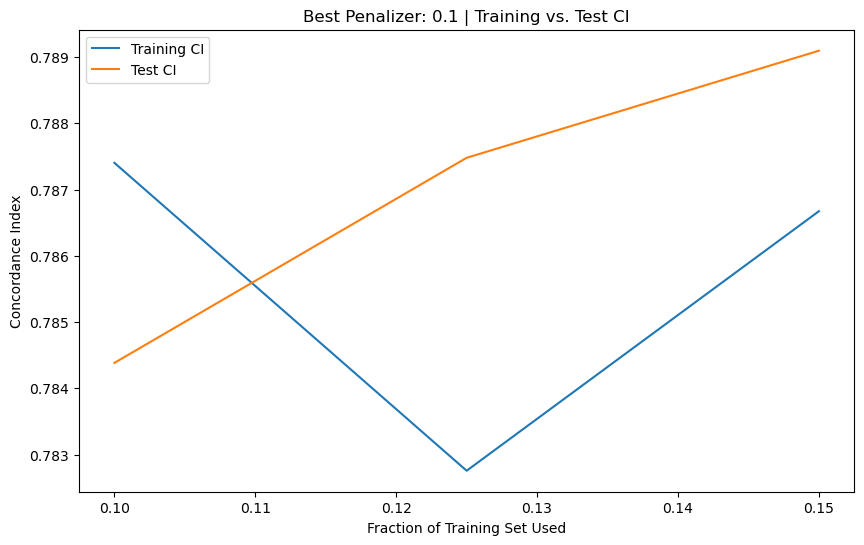

In [95]:
# Plotting the best results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Training CI')
plt.plot(train_sizes, test_scores, label='Test CI')
plt.title(f'Best Penalizer: {best_penalizer} | Training vs. Test CI')
plt.xlabel('Fraction of Training Set Used')
plt.ylabel('Concordance Index')
plt.legend()
plt.show()

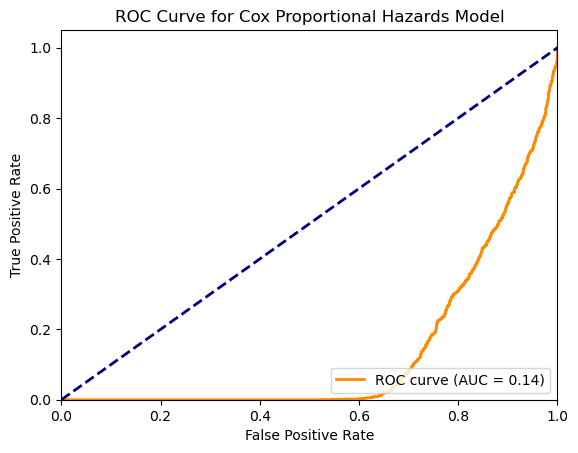

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming best_cph is your fitted CoxPHFitter object and test_df contains your test data
survival_probabilities = -best_cph.predict_partial_hazard(test_df)
event_observed = test_df['Non_adhere']

# Treat each time point as a separate binary outcome
fpr, tpr, _ = roc_curve(event_observed, survival_probabilities, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Cox Proportional Hazards Model')
plt.legend(loc="lower right")
plt.show()


In [117]:
#cph.summary
significant_summary = cph.summary.loc[cph.summary['p'] < 0.05]
significant_summary_sorted = significant_summary.sort_values(by='exp(coef)', ascending=False)
significant_summary_sorted.iloc[:,0:2]

,coef,exp(coef)
covariate,,
risk_nums_1060_w5,0.192546,1.212332
REFILL_CD_std_w15,0.071355,1.073962
ADMINRTE_CD_SC_w15,0.044817,1.045836
DAYSSUPP_NBR_std_w15,0.004679,1.004690
FORMULARY_IND_Y_w52,0.004491,1.004501
PLANDRUGST_CD_F_w52,0.004324,1.004333
DAYSSUPP_NBR_max_w15,0.003909,1.003916
DAYSSUPP_NBR_sum_w52,0.000083,1.000083
cas_nums_308_w52,-0.014093,0.986006
